In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import required libraries

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


### Load MNIST and prepare data

In [ ]:

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# Normalize to [0,1] and expand channel dim for ConvNet
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

# For dense model we will flatten; for CNN we need channel dimension
x_train_cnn = np.expand_dims(x_train, -1)
x_test_cnn  = np.expand_dims(x_test, -1)

num_classes = 10



(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


### Visualize a few samples

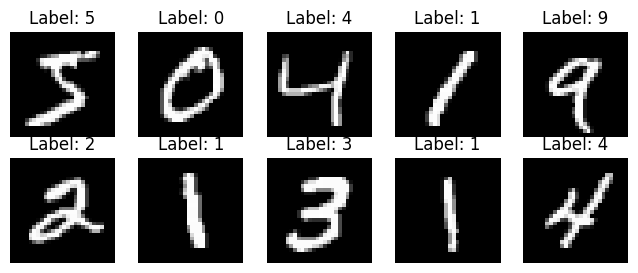

In [ ]:
plt.figure(figsize=(8,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()


### Dense (MLP) model

In [ ]:
def build_dense():
    model = keras.Sequential([
        layers.Flatten(input_shape=(28,28)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

dense_model = build_dense()
dense_model.summary()

history_dense = dense_model.fit(x_train, y_train,
                                validation_split=0.1,
                                epochs=8,
                                batch_size=128)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7951 - loss: 0.6975 - val_accuracy: 0.9622 - val_loss: 0.1368
Epoch 2/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9455 - loss: 0.1818 - val_accuracy: 0.9687 - val_loss: 0.1043
Epoch 3/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9595 - loss: 0.1338 - val_accuracy: 0.9720 - val_loss: 0.0877
Epoch 4/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9682 - loss: 0.1058 - val_accuracy: 0.9742 - val_loss: 0.0777
Epoch 5/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9721 - loss: 0.0883 - val_accuracy: 0.9773 - val_loss: 0.0783
Epoch 6/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9762 - loss: 0.0769 - val_accuracy: 0.9787 - val_loss: 0.0709
Epoch 7/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9788 - loss: 0.0664 - val_accuracy: 0.9780 - val_loss: 0.0712
Epoch 8/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9814 - loss: 0.0587 - val_accuracy: 0.9797 - v

### Small CNN

In [ ]:
def build_cnn():
    model = keras.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

cnn_model = build_cnn()
cnn_model.summary()

history_cnn = cnn_model.fit(x_train_cnn, y_train,
                            validation_split=0.1,
                            epochs=10,
                            batch_size=128)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8258 - loss: 0.5677 - val_accuracy: 0.9793 - val_loss: 0.0640
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9744 - loss: 0.0834 - val_accuracy: 0.9882 - val_loss: 0.0463
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9829 - loss: 0.0557 - val_accuracy: 0.9878 - val_loss: 0.0390
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9862 - loss: 0.0433 - val_accuracy: 0.9902 - val_loss: 0.0372
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9875 - loss: 0.0392 - val_accuracy: 0.9915 - val_loss: 0.0317
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9907 - loss: 0.0291 - val_accuracy: 0.9915 - val_loss: 0.0327
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9920 - loss: 0.0250 - val_accuracy: 0.9903 - val_loss: 0.0348
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9917 - loss: 0.0248 - val_accuracy: 0

### Evaluate on test set

In [ ]:
# Dense evaluate
loss_d, acc_d = dense_model.evaluate(x_test, y_test, verbose=0)
print(f"Dense model — Test accuracy: {acc_d:.4f}, loss: {loss_d:.4f}")

# CNN evaluate
loss_c, acc_c = cnn_model.evaluate(x_test_cnn, y_test, verbose=0)
print(f"CNN model — Test accuracy: {acc_c:.4f}, loss: {loss_c:.4f}")


Dense model — Test accuracy: 0.9781, loss: 0.0714
CNN model — Test accuracy: 0.9915, loss: 0.0255


### Plot training curves

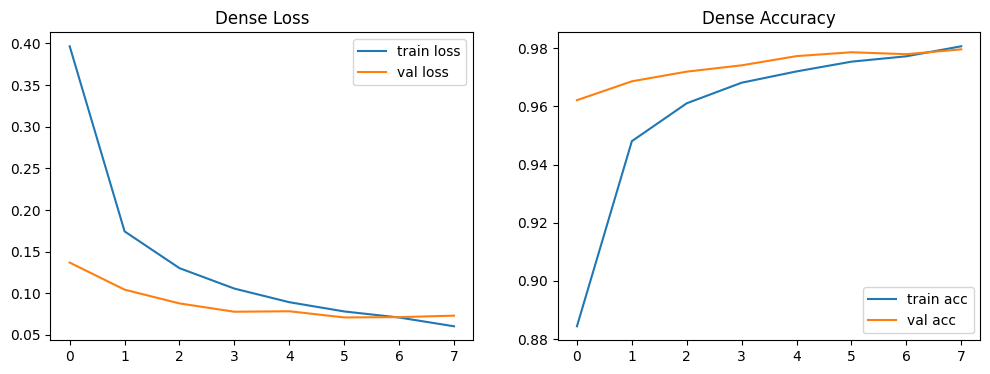

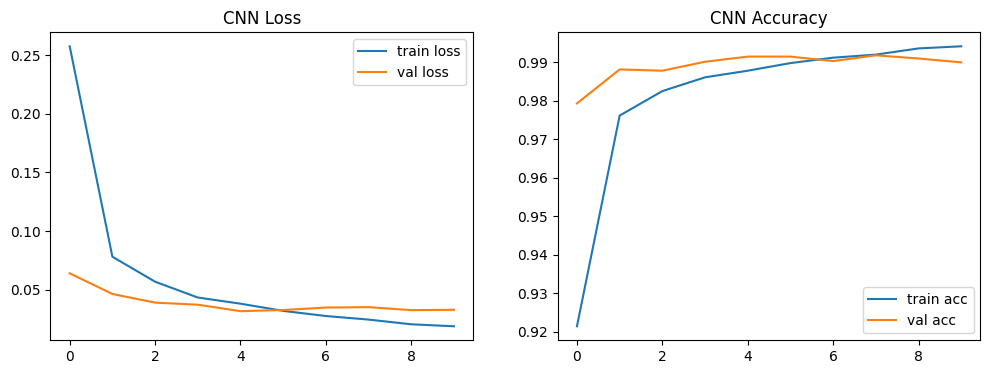

In [ ]:
def plot_history(h, title=''):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h.history['loss'], label='train loss')
    plt.plot(h.history['val_loss'], label='val loss')
    plt.title(title + ' Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(h.history['accuracy'], label='train acc')
    plt.plot(h.history['val_accuracy'], label='val acc')
    plt.title(title + ' Accuracy')
    plt.legend()
    plt.show()

plot_history(history_dense, 'Dense')
plot_history(history_cnn, 'CNN')


### Confusion matrix and classification report

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


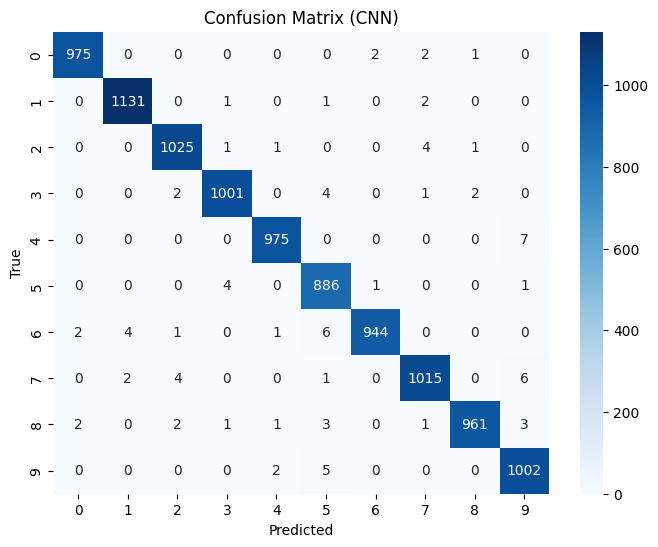

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:

y_pred = np.argmax(cnn_model.predict(x_test_cnn), axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (CNN)')
plt.show()

# Classification report
print(classification_report(y_test, y_pred))


### Show some wrong predictions + model confidences

Number of misclassifications: 85


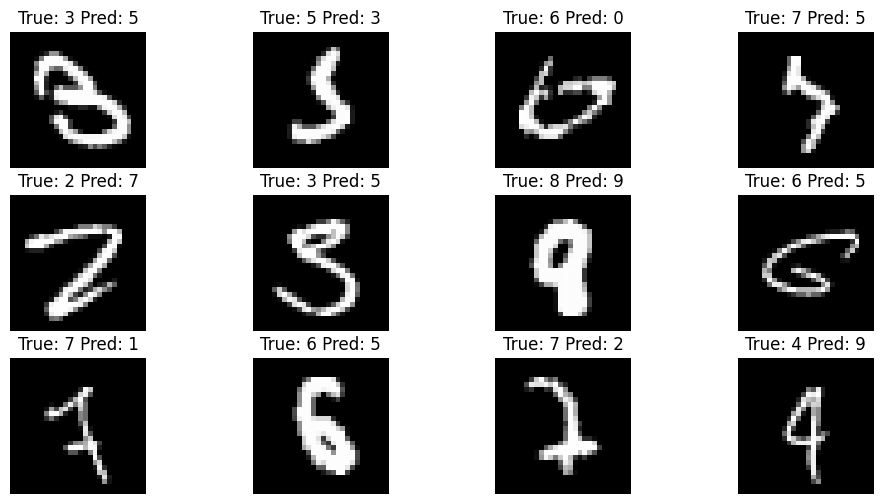

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
0 label: 7 pred: 7 conf: 1.0
1 label: 2 pred: 2 conf: 1.0
2 label: 1 pred: 1 conf: 1.0
3 label: 0 pred: 0 conf: 1.0
4 label: 4 pred: 4 conf: 1.0
5 label: 1 pred: 1 conf: 1.0
6 label: 4 pred: 4 conf: 0.997
7 label: 9 pred: 9 conf: 1.0
8 label: 5 pred: 5 conf: 0.999
9 label: 9 pred: 9 conf: 1.0


In [ ]:
mis_idx = np.where(y_pred != y_test)[0]
print("Number of misclassifications:", len(mis_idx))

plt.figure(figsize=(12,6))
for i, idx in enumerate(mis_idx[:12]):
    plt.subplot(3,4,i+1)
    plt.imshow(x_test[idx], cmap='gray')
    plt.title(f"True: {y_test[idx]} Pred: {y_pred[idx]}")
    plt.axis('off')
plt.show()

probs = cnn_model.predict(x_test_cnn[:10])
for i, p in enumerate(probs):
    print(i, "label:", y_test[i], "pred:", np.argmax(p), "conf:", np.max(p).round(3))


### Save the trained model (to Drive)

In [ ]:
# Save to Drive (path example)
save_path = '/content/drive/MyDrive/mnist_cnn.h5'
cnn_model.save(save_path)
print("Saved model to:", save_path)


Saved model to: /content/drive/MyDrive/mnist_cnn.h5


### Load & inference example

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
True: 7 Predicted: 7


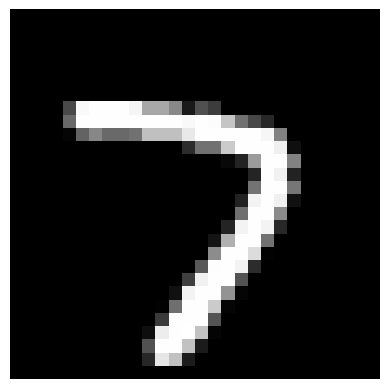

In [ ]:
# load
from tensorflow.keras.models import load_model
m = load_model('/content/drive/MyDrive/mnist_cnn.h5')

# predict on a single example
idx = 17
img = x_test_cnn[idx:idx+1]
pred = np.argmax(m.predict(img), axis=1)[0]
print("True:", y_test[idx], "Predicted:", pred)
plt.imshow(x_test[idx], cmap='gray'); plt.axis('off'); plt.show()
